## Adaptation of CI - A multi-level approach
In this example we demonstrate how adaptations of different levels (hazard-, asset-, network- and system-level) can be appraised based on their cost of adaptation, risk, and benefits of adaptation. This notebook covers the calculation of indirect losses; there is also a notebook for direct damages and a subsequent notebooks for adaptation appraisal.

### Adaptation of CI - Indirect losses
Using the hazard and assets overlay of the direct damages notebook, this notebook shows how historical freight volumes and passenger ridership are used to calculate indirect losses. The freight losses are calculated using the incremental cost of shipping by road vs rail, while the passenger losses are calculated based on the ticketing revenue loss. Freight and passenger ridership data from Eurostat are used. 

In [67]:
#ADDITIONAL DEPENDENCIES
# !pip install triangle
# !pip install rasterio
# !pip install geopy
# !pip install osmnx

In [68]:
import os
# os.chdir('path/to/book/directory')
# os.chdir('..')
from src.ci_adapt_utilities import *
import matplotlib.pyplot as plt

data_path = Path(os.getcwd() + '/data')
interim_data_path = data_path / 'interim' / 'indirect_damages'


Load default configuration and model parameters

In [69]:
# Load configuration with ini file (created running config.py)
config_file=Path(os.getcwd() + '/config_ci_adapt_test.ini')
hazard_type, infra_type, country_code, country_name, hazard_data_subfolders, asset_data, vulnerability_data = load_config(config_file)

Load asset data and transport cost data 

In [70]:
assets, geom_dict, _, return_period_dict, _, rp_spec_priority, average_road_cost_per_ton_km, average_train_cost_per_ton_km, average_train_load_tons = startup_ci_adapt(data_path, config_file)
# Reproject assets to match route data projection
assets_4326=assets.to_crs(4326)
assets_4326['geometry']=assets_4326['geometry'].make_valid()

675 assets loaded.


Load the route data for the area of interest

In [71]:
# Load route data
route_data_source=data_path/r'input\traffic\NET_SEGMENTS_EU_EFTA_Filtered_0.xlsx'
route_data=prepare_route_data(route_data_source, assets)
route_data.head(3)

,From,To,From_Latitude,From_Longitude,To_Latitude,To_Longitude,goods,passengers,Country,geometry_from,geometry_to
3192,Büdesheim-Dromersheim,Bingen (Rhein) Stadt,49.934,7.946,49.971,7.904,1.000,"6,078.000",DE,POINT (884511.9871012702 6434834.058730009),POINT (879858.6676332649 6441241.378778344)
3250,Bingen (Rhein) Stadt,Büdesheim-Dromersheim,49.971,7.904,49.934,7.946,1.000,"5,804.000",DE,POINT (879858.6676332649 6441241.378778344),POINT (884511.9871012702 6434834.058730009)
4044,Langenlonsheim,Stromberg (Hunsrück),49.903,7.901,49.947,7.769,2.000,0.000,DE,POINT (879497.2043410999 6429427.441768809),POINT (864887.3582970536 6437118.144174217)


Create the rail network and graph

In [72]:
# Prepare network to create graph
from snkit.network import *
from src.network_functions import _network_to_nx

net=Network(edges=assets_4326)
net=add_endpoints(network=net)
net=link_nodes_to_edges_within(network=net, distance=0.0000014)
net=add_ids(network=net)
net=add_topology(network=net)
net.set_crs(4326)
net.edges=net.edges.to_crs(3857)
net.nodes=net.nodes.to_crs(3857)

# Create graph from network
merged_rail_graph = _network_to_nx(net)

# Create a MultiDiGraph from the graph
graph_0=nx.MultiDiGraph(merged_rail_graph)

Add weights based on railway length and find the shortest paths for all each origin/destination pair

In [73]:
# Removing floats from osm_id
for u,v,k,attr in graph_0.edges(keys=True, data=True):
    if type(attr['osm_id'])==type(float()):
        graph_0[u][v][k]['osm_id'] = ''
# Set weights for edges
graph_0 = set_edge_weights(assets, graph_0)
graph_0, shortest_paths = find_shortest_paths_capacities(graph_0, route_data, simplified=True)

Possible terminals: 716
Failed to find paths for 0 routes


Create parallel "virtual" graph to reroute isolated trips

In [74]:
# Create initial virtual graph
graph_v0=create_virtual_graph(graph_0)
graph_v=graph_v0.copy()

Creating virtual graph...
Success: only int type values


Load direct damage results and find the indirect impacts for each basin (local flooding)

In [75]:
# Load direct damages results
if 'collect_output' not in locals():
    collect_output_path = data_path/'interim/collected_flood_runs/sample_collected_run.pkl'
    with open(collect_output_path, 'rb') as f:
        collect_output = pickle.load(f)

# Loop through the event files and calculate the economic impact of each event
disrupted_asset_lengths={}
disrupted_shortest_paths={}
event_impacts={}
event_impacts_breakdown={}
disrupted_edges_by_basin={}

for hazard_map, asset_dict in collect_output.items():
    disrupted_assets = [key for key in asset_dict.keys()]
    disrupted_osm_ids = [
        assets.loc[asset_index]['osm_id'] 
        for asset_index in disrupted_assets 
        if asset_index in assets.index and (
            (assets.loc[asset_index]['bridge'] != 'yes') 
            and (assets.loc[asset_index]['tunnel'] != 'yes')
            and (assets.loc[asset_index]['osm_id'] is not None)
            )
        ]
    if len(disrupted_osm_ids)==0:
        continue

    disrupted_edges=[]
    
    for u,v,attr in graph_0.edges(data=True):
        if 'osm_id' not in attr: 
            continue
        if attr['bridge']=='yes' or attr['tunnel']=='yes':
            continue
        matching_ids=[osm_id for osm_id in attr['osm_id'].split('; ') if osm_id in disrupted_osm_ids]
        if len(matching_ids)>0:
            disrupted_edges.append((u,v))
            
    print(f'Disrupted edges: {len(disrupted_edges)}')

    # If there are no disrupted edges in the event, move to next event
    if len(disrupted_edges)==0:
        continue
    
    disrupted_edges_by_basin[hazard_map]=disrupted_edges
    disrupted_shortest_paths[hazard_map]=calculate_new_paths(graph_v0, shortest_paths, disrupted_edges)

    if disrupted_shortest_paths[hazard_map] == {}: # No disrupted paths, no economic impact
        print(f'No shortest paths disrupted for {hazard_map}. No economic impact.')
        continue

    print('Calculating economic impact...')
    impact=calculate_economic_impact_shortest_paths(hazard_map, graph_v, shortest_paths, disrupted_shortest_paths[hazard_map], average_train_load_tons, average_train_cost_per_ton_km, average_road_cost_per_ton_km)
    event_impacts[hazard_map]=impact[0] # Save the total impact
    event_impacts_breakdown [hazard_map] = impact # Save the breakdown of the impact
    print(hazard_map, impact)

Disrupted edges: 26
Calculating economic impact...
flood_DERP_RW_H_4326_2080430240 (5427421.889182759, 2820390.5045673745, 2607031.3846153845)
Disrupted edges: 24
Calculating economic impact...
flood_DERP_RW_H_4326_2080430320 (1711264.6439201704, 47212.41315093989, 1664052.2307692305)
Disrupted edges: 98
Calculating economic impact...
flood_DERP_RW_L_4326_2080428500 (74788268.74428403, 47059358.74428403, 27728910.000000004)
Disrupted edges: 60
Calculating economic impact...
flood_DERP_RW_L_4326_2080430240 (54274218.89182758, 28203905.04567374, 26070313.846153848)
Disrupted edges: 78
Calculating economic impact...
flood_DERP_RW_L_4326_2080430320 (30944709.817721482, 14304187.510029174, 16640522.307692308)
Disrupted edges: 50
Calculating economic impact...
flood_DERP_RW_M_4326_2080430240 (10854843.778365519, 5640781.009134749, 5214062.769230769)
Disrupted edges: 60
Calculating economic impact...
flood_DERP_RW_M_4326_2080430320 (6188941.963544296, 2860837.5020058355, 3328104.461538461)


Save results for basin floods

In [76]:
cols_names=['total_eur', 'freight_eur', 'passengers_eur'] 
event_impacts_breakdown_df = pd.DataFrame.from_dict(event_impacts_breakdown, orient='index', columns=cols_names)
event_impacts_breakdown_df.to_csv(data_path/ 'output' / 'impacts' / 'indirect_losses_basins.csv')

Find the indirect impacts from river mainstem flooding

In [77]:
# now repeat collecting all the disrupted edges accross all maps with the same return period
all_disrupted_edges={}
all_disrupted_shortest_paths={}
full_flood_event={}
full_flood_event_breakdown={}

haz_map_names=['flood_DERP_RW_H', 'flood_DERP_RW_M', 'flood_DERP_RW_L']

for haz_map in haz_map_names:
    all_disrupted_edges[haz_map]=[]
    for key, value in disrupted_edges_by_basin.items():
        if haz_map in key:
            all_disrupted_edges[haz_map].extend(value)
    all_disrupted_edges[haz_map]=list(set(all_disrupted_edges[haz_map]))
    print(f'Number of disrupted edges for {haz_map}: ', len(all_disrupted_edges[haz_map]))
    print('Calculating shortest paths for: ', haz_map)
    all_disrupted_shortest_paths[haz_map]=calculate_new_paths(graph_v0, shortest_paths, all_disrupted_edges[haz_map])

    if all_disrupted_shortest_paths[haz_map] == {}: # No disrupted paths, no economic impact
        print(f'No shortest paths disrupted for {haz_map}. No economic impact.')
        continue

    print('Calculating economic impact...')    
    impact_breakdown=calculate_economic_impact_shortest_paths(haz_map, graph_v, shortest_paths, all_disrupted_shortest_paths[haz_map], average_train_load_tons, average_train_cost_per_ton_km, average_road_cost_per_ton_km)
    full_flood_event_breakdown[haz_map]=impact_breakdown
    full_flood_event[haz_map]=impact_breakdown[0]
    print(f'Impact for {haz_map} in M Eur: {impact_breakdown[0]/1e6 :.2f}')

# save the data
full_flood_event_breakdown_df = pd.DataFrame.from_dict(full_flood_event_breakdown, orient='index', columns=cols_names)
full_flood_event_breakdown_df.to_csv(data_path/ 'output' / 'impacts' / 'indirect_losses_full_flood_event.csv')

with open(interim_data_path / 'all_disrupted_edges.pkl', 'wb') as f:
    pickle.dump(all_disrupted_edges, f)
with open(interim_data_path / 'full_flood_event.pkl', 'wb') as f:
    pickle.dump(full_flood_event, f)


Number of disrupted edges for flood_DERP_RW_H:  50
Calculating shortest paths for:  flood_DERP_RW_H
Calculating economic impact...
Impact for flood_DERP_RW_H in M Eur: 5.93
Number of disrupted edges for flood_DERP_RW_M:  102
Calculating shortest paths for:  flood_DERP_RW_M
Calculating economic impact...
Impact for flood_DERP_RW_M in M Eur: 11.86
Number of disrupted edges for flood_DERP_RW_L:  220
Calculating shortest paths for:  flood_DERP_RW_L
Calculating economic impact...
Impact for flood_DERP_RW_L in M Eur: 103.13


Visualise indirect losses and calculate risk

In [78]:
files = [file for file in os.listdir(data_path / 'interim/collected_flood_runs') if file.endswith('.pkl') and file.startswith('overlay')]
basins_list=list(set([int(file.split('.')[0].split('_')[-1]) for file in files]))
basin_dict = {}
for basin in basins_list:
    basin_dict[basin] = {}
    for key in event_impacts.keys():
        if not str(basin) in key:
            continue
        if str(basin) in key:
            basin_dict[basin][key.split('_RW')[-1][0:3]] = event_impacts[key]

for rp in return_period_dict.keys():
    # add rp as a key to all nested dictionaries with 0 as a value if the rp is not already a key
    for basin in basin_dict.keys():
        if rp not in basin_dict[basin].keys():
            basin_dict[basin][rp] = 0

basin_dict_df = pd.DataFrame.from_dict(basin_dict, orient='index')
basin_dict_df

,_H_,_L_,_M_
2080430240,"5,427,421.889","54,274,218.892","10,854,843.778"
2080428500,0.000,"74,788,268.744",0.000
2080430320,"1,711,264.644","30,944,709.818","6,188,941.964"


In [79]:
"""
Return period definitions for Rhineland Palatinate (DERP) based on the report by Rauthe M, et al. (2020):
_H_=10-25y 
_M_=100y
_L_=200y
"""
# Add climate change: calculate the dynamic return periods based on flat increase factors. 
increase_factor = {
    '_H_': 2,
    '_M_': 4.21,
    '_L_': 5.86
} # Mentaschi, et al. (2016) 

num_years = 100
return_periods = calculate_dynamic_return_periods(return_period_dict, num_years, increase_factor)

aggregated_df_by_basin = {}
ead_by_ts_by_basin = {}

for basin, damage_dict in basin_dict.items():
    if len(damage_dict) == 0:
        continue

    aggregated_df_by_basin[basin] = pd.DataFrame.from_dict(damage_dict, orient='index', columns=['Total indirect damage'])
    aggregated_df_by_basin[basin]['Return Period'] = [return_periods[index] for index in aggregated_df_by_basin[basin].index]
    aggregated_df_by_basin[basin] = aggregated_df_by_basin[basin].sort_values('Return Period', ascending=True)
    probabilities = [[1 / rp for rp in ts] for ts in aggregated_df_by_basin[basin]['Return Period']]
    aggregated_df_by_basin[basin]['Probability'] = probabilities
    dmgs = []

    for ts in range(len(probabilities[0])):
        dmgs_m = []

        for rp in range(len(probabilities)-1):
            d_rp= probabilities[rp][ts] - probabilities[rp + 1][ts]
            trap_damage_m = 0.5 * (aggregated_df_by_basin[basin]['Total indirect damage'].iloc[rp] + aggregated_df_by_basin[basin]['Total indirect damage'].iloc[rp + 1])
            dmgs_m.append(d_rp * trap_damage_m)
        
        # Add the portion of damages corresponding to the tails of the distribution
        d0_rp = probabilities[-1][ts]
        damage_m0 = max(aggregated_df_by_basin[basin]['Total indirect damage'])
        dmgs_m.append(d0_rp * damage_m0)

        d_end_rp = (1/4)-probabilities[0][ts]
        damage_m_end = 0.5 * min(aggregated_df_by_basin[basin]['Total indirect damage'])

        dmgs_m.append(d_end_rp * damage_m_end)

        dmgs.append((sum(dmgs_m)))
    
    ead_by_ts_by_basin[basin] = pd.DataFrame(dmgs, columns=['Total indirect damage'])


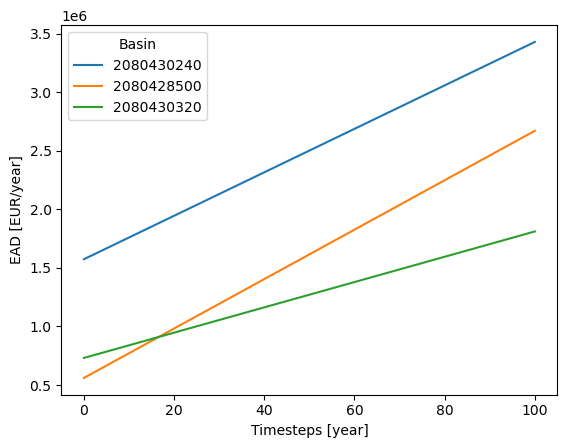

In [80]:
# Find total damages by basin over the 100 y period
total_damages_by_basin = {basin: ead_by_ts_by_basin[basin].values.sum() for basin in ead_by_ts_by_basin.keys()}

#plot the EAD for each basin    
for basin, ead_df in ead_by_ts_by_basin.items():
    plt.plot(ead_df, label=basin)
    plt.legend(title='Basin')
    plt.xlabel('Timesteps [year]')
    plt.ylabel('EAD [EUR/year]')
plt.show()
        

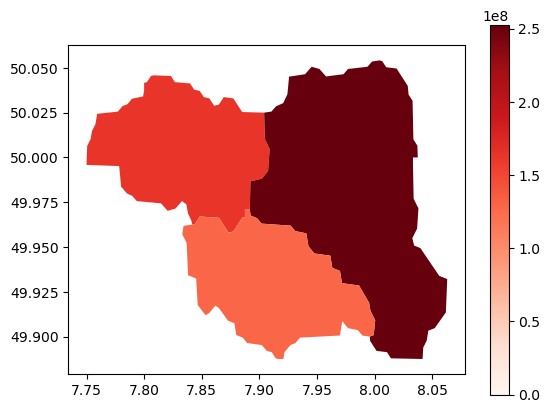

In [81]:
def georeference_damages(gdf, damages):
    # Initialize 'damage' column to 0
    gdf['damage'] = 0
    damage_map = {key: value for key, value in damages.items() if key in gdf['HYBAS_ID'].tolist()}
    gdf['damage'] = gdf['HYBAS_ID'].map(damage_map).fillna(0)
    return gdf

# Load basins GeoDataFrame
basins_path = data_path / 'Floods' / 'basins' / 'hybas_eu_lev01-12_v1c' / 'hybas_eu_lev08_v1c_valid.shp'
basins = gpd.read_file(basins_path)

basins_filtered = basins[basins['HYBAS_ID'].isin(basins_list)].copy()

ead_gdf = georeference_damages(basins_filtered, total_damages_by_basin)
ead_gdf.plot(column='damage', legend=True, cmap='Reds', vmin=0)
ead_gdf.to_parquet(data_path / 'output' / 'impacts' / 'indirect_losses_basins.pq')
plt.show()

In [82]:
# save G and shortest paths to pickle files
pickle.dump(graph_0, open(interim_data_path / 'graph_0.pkl', 'wb'))
pickle.dump(shortest_paths, open(interim_data_path / 'shortest_paths.pkl', 'wb'))
pickle.dump(disrupted_edges_by_basin, open(interim_data_path / 'disrupted_edges_by_basin.pkl', 'wb'))
pickle.dump(disrupted_shortest_paths, open(interim_data_path / 'disrupted_shortest_paths.pkl', 'wb'))
pickle.dump(event_impacts, open(interim_data_path / 'event_impacts.pkl', 'wb'))
pickle.dump(ead_gdf, open(interim_data_path / 'ead_gdf.pkl', 'wb'))
pickle.dump(ead_by_ts_by_basin, open(interim_data_path / 'ead_by_ts_by_basin.pkl', 'wb'))
print('Data saved to pickle files.')


Data saved to pickle files.
